In [1]:
%pylab inline

import pandas as pd
import pickle
import matplotlib.dates as md
import statsmodels.api as sm

from scipy.optimize import minimize

tableau = pickle.load(open('tableau.colors', 'rb'))

rcParams['figure.figsize'] = (10,8)
rcParams['axes.grid'] = True
rcParams['lines.linewidth'] = 2.5
rcParams['axes.prop_cycle'] = cycler('color', tableau)

xfmt = md.DateFormatter('%H:%M:%S')

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('~/Downloads/coinbaseUSD.csv', header=0, names=['t', 'px', 'sz'])
df.t *= 1e9
df.t = pd.to_datetime(df.t)

# Eliminate early data with insufficient liquidity.
df = df.loc[df.t > "2015-09-03"]

In [53]:
def front(df, day, days):
    sliced = df.loc[(df.t - pd.to_datetime(day+' 00:00:00')) > pd.Timedelta(days=0)]
    sliced = sliced.loc[(sliced.t - pd.to_datetime(day+' 00:00:00')) < pd.Timedelta(days=days)]
    return sliced

def oneday(df, day):
    return front(df, day, 1)

def around(df, stamp, size):
    sliced = df.loc[abs(df.t - pd.to_datetime(stamp)) < pd.Timedelta(days=size/24.)]
    return sliced

In [29]:
def modified(df, fields):
    if 'pxd' in fields:
        df['pxd'] = df.px - df.px.shift(1)
    if 'updn' in fields:
        df['updn'] = 1 * (df.px > df.px.shift(1)) - 1 * (df.px < df.px.shift(1))
    return df

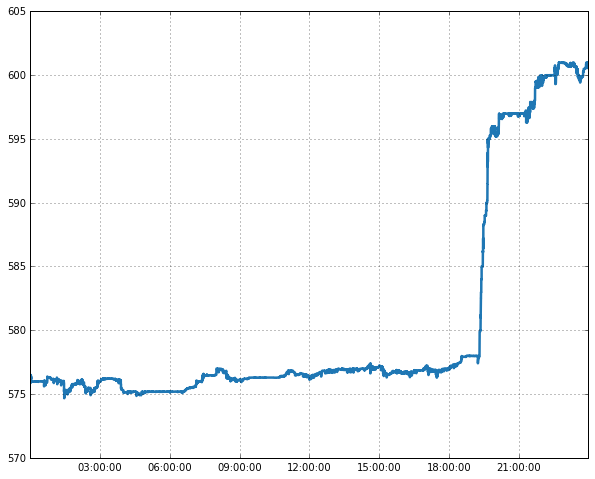

In [5]:
third = oneday(df, '2016-09-03')
plot(third.t, third.px)

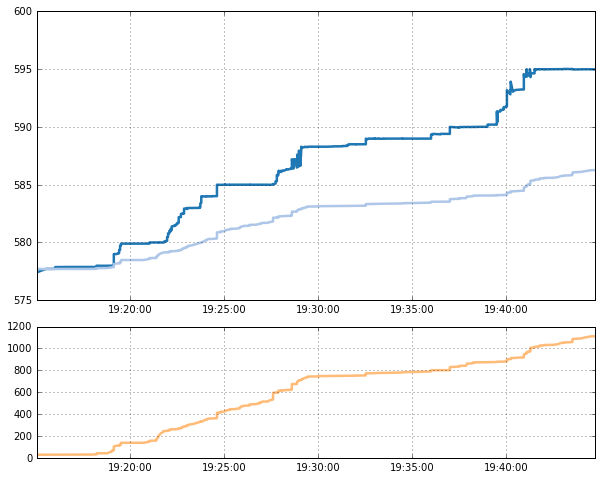

In [7]:
tiny = around(third, '2016-09-03 19:30:00', 0.25)

ax = []
ax.append(subplot2grid((3,1),(0,0), rowspan=2))
ax.append(subplot2grid((3,1),(2,0)))

vwap = (tiny.px * tiny.sz).cumsum() / tiny.sz.cumsum()

ax[0].plot(tiny.t, tiny.px)
ax[0].plot(tiny.t, vwap)
ax[1].plot(tiny.t, tiny.sz.cumsum(), c=tableau[3])

ax[0].xaxis.set_major_formatter(xfmt)
ax[1].xaxis.set_major_formatter(xfmt)

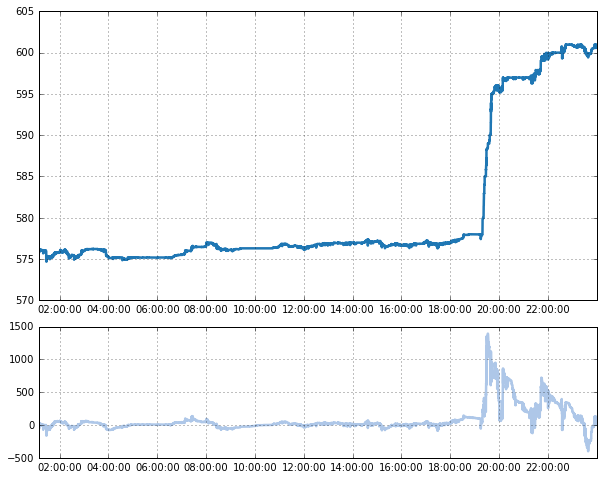

In [585]:
ax = []
ax.append(subplot2grid((3,1),(0,0), rowspan=2))
ax.append(subplot2grid((3,1),(2,0)))

signal = data.sz.rolling(n).sum() * (data.px - vwap)
ax[0].plot(data.t[n:], data.px[n:])
ax[1].plot(data.t[n:], signal[n:], c=tableau[1])

ax[0].xaxis.set_major_formatter(xfmt)
ax[1].xaxis.set_major_formatter(xfmt)

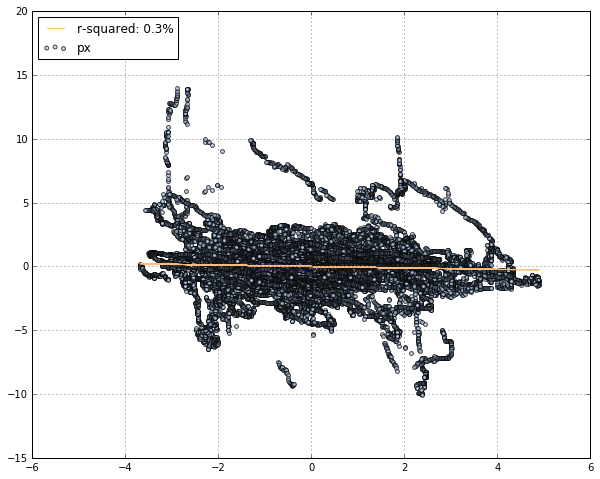

In [57]:
data = modified(front(df, '2016-08-01', 10), ['updn', 'pxd'])

n = 1000; m = 500
A = data.updn.rolling(n).sum()[n:-m]
B = (data.px.shift(-m) - data.px)[n:-m]

A = (A - A.mean()) / A.std()
B = (B - B.mean()) / B.std()

scatter(A, B, s=15, alpha=0.7, c=tableau[1])
fitted = sm.OLS(B, A).fit()
plot(A, fitted.params[0]*A, lw=1, c=tableau[3],
     label='r-squared: %0.1f%%' % (100.*fitted.rsquared))
legend(loc='upper left')